In [1]:
import re
import spacy 
from model.model import IndexModel, SemanticIndex, SyntacticIndex
import joblib
from utils.utils import doc2graph, vizGraph
import json 

import matplotlib.pyplot as plt

import pandas as pd 

from nervaluate import Evaluator

import copy

%load_ext autoreload
%autoreload 2

In [2]:
with open('../data/emontal-ner-er/emontal-ner.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
data

{'classes': ['MISC', 'PER', 'LOC', 'TIME'],
 'annotations': [['Robespierre le jeune fut envoyé en mission dans le département de la llauleSaône au mois de mai 1704, trois mois à peu près avant le 0 Thermidor.',
   {'entities': []}],
  ['Bernard était un homme de cinq pieds neuf pouces, d’une cinquantaine d’années, dont la taille était droite et très menue, le port roide et assuré, la physionomie d’une imperturbable austérité que n’avait jamais égarée un sourire.',
   {'entities': []}],
  ['Le Ballon d’Alsace qui est déjà un séjour d’été des plus agréables, devient aussi un centre de sports d’hiver.',
   {'entities': [[3, 18, 'LOC'], [104, 109, 'LOC']]}],
  ['— M. Beinichê Séraphin, d’Etueffont-Haut, a été nommé cantonnier, à Giromagny,en remplacement de M. Petitjean Alphonse, démissionnaire.',
   {'entities': [[2, 22, 'PER'], [54, 64, 'MISC']]}],
  ['— M. Laibe Joseph, de Faverois, a été nommé cantonnier à Faverois, en remplacement de M. Marconnet Célestin, démissionnaire.',
   {'entit

In [3]:
with open('../data/wikidata-ner/wikidata-ner.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
data

{'classes': ['MISC', 'PER', 'LOC', 'TIME'],
 'annotations': [['Cet article est une ébauche concernant une localité italienne et le Piémont.',
   {'entities': []}],
  ['Scarmagno (en français Scarmagne) est une commune italienne de la ville métropolitaine de Turin dans la région Piémont en Italie.',
   {'entities': [[0, 9, 'LOC'], [122, 128, 'LOC']]}],
  ['Vous pouvez partager vos connaissances en l’améliorant (comment ?) selon les recommandations des projets correspondants.',
   {'entities': []}],
  ['la suite des élections municipales de 2008, le conseil était composé de la manière suivante :',
   {'entities': []}],
  ["Après la Seconde Guerre mondiale, Sarajevo devient la capitale d'une République populaire puis, en 1963, socialiste de Bosnie-Herzégovine, au sein de la République fédérale populaire, puis, en 1963, socialiste de Yougoslavie.",
   {'entities': [[34, 42, 'LOC'], [119, 137, 'LOC']]}],
  ["Après la Seconde Guerre mondiale, Sarajevo devient la capitale d'une République pop

In [3]:
max_len = len(data['annotations'])
split = int(max_len / 2)
data_dev = copy.deepcopy(data) 
data_test = copy.deepcopy(data)
n = 25 
data_dev['annotations'] = data_dev['annotations'][:split + n]
data_test['annotations'] = data_test['annotations'][split + n:]

In [21]:
data_dev['annotations'][-1], data_test['annotations'][-1]

(['-AIrred-Charles-Gaston, marquis de Béthisy, est né à Paris le 10 mars 1815.',
  {'entities': [[0, 22, 'PER'], [62, 74, 'TIME']]}],
 ["C. J. F. Le séminariste Maurice Pierre, du 47e d'artillerie, a quitté Besançon pour le fort du Salbert, près de Belfort : nos regrets l'accompagnent dans sa triste sollitude.",
  {'entities': [[84, 102, 'LOC'], [112, 119, 'LOC']]}])

In [4]:
from collections import Counter 

def get_stats(data):

    print('Num Sent', len(data['annotations']))
    ents = [y[-1] for x in data['annotations'] for y in x[1]['entities']]
    c = Counter(ents)
    print(c.most_common())

In [23]:
print('Total')
get_stats(data)

print('Dev')
get_stats(data_dev)

print('Test')
get_stats(data_test)

Total
Num Sent 426
[('PER', 305), ('LOC', 195), ('TIME', 102), ('MISC', 68)]
Dev
Num Sent 238
[('PER', 137), ('LOC', 107), ('TIME', 62), ('MISC', 28)]
Test
Num Sent 188
[('PER', 168), ('LOC', 88), ('TIME', 40), ('MISC', 40)]


In [7]:
project = '../data/Q5-Property:P625'
semInd = SemanticIndex(project)
synInd = SyntacticIndex(project)

indexModel = IndexModel(extractor=synInd, classifier=semInd)

In [8]:
from gensim.models import KeyedVectors
embeddings_path = '../data/embeddings/conceptnet_fr-19.08-clean_simpler'
we = KeyedVectors.load(embeddings_path, mmap='r')

2023-12-28 09:50:29 gensim.utils INFO: loading KeyedVectors object from ../data/embeddings/conceptnet_fr-19.08-clean_simpler
2023-12-28 09:50:29 gensim.utils INFO: loading vectors from ../data/embeddings/conceptnet_fr-19.08-clean_simpler.vectors.npy with mmap=r
2023-12-28 09:50:29 gensim.utils INFO: KeyedVectors lifecycle event {'fname': '../data/embeddings/conceptnet_fr-19.08-clean_simpler', 'datetime': '2023-12-28T09:50:29.758447', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 08:50:36) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'loaded'}


In [9]:
clf = joblib.load(f"{project}/model/mlClassifier/clf.joblib")
mlModel = IndexModel(extractor=synInd, classifier=clf, we=we)

In [5]:
per_loc_model = spacy.load('fr_EMONTAL_NER_PER_LOC_TIME')

/Volumes/T7/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# base_ner_model = spacy.load('fr_EMONTAL_NER')

In [14]:
nlp = spacy.load('fr_core_news_lg')

In [6]:
dict_ent = {
    'Q5': 'PER',
    'Property:P625': 'LOC',
    'time': 'TIME',
    'Misc': 'Misc',
    'pers': 'PER',
    'loc': 'LOC',
    'time': 'TIME'
}

In [7]:
def eval2df(data_eval, name):
    index_list = ['ent_type', 'partial', 'strict', 'exact']
    df = pd.DataFrame.from_dict([{
        'P': data_eval[i]['precision'], 
        'R': data_eval[i]['recall'],
        'F1': data_eval[i]['f1']}
        for i in index_list])
    df.index = pd.MultiIndex.from_tuples([(name, x) for x in index_list], names=['model', 'eval']) 
    return df

def evaltype2df(data_eval, name):
    df = pd.DataFrame.from_dict(data_eval)
    index_list = ['ent_type', 'partial', 'strict', 'exact']

    for k in data_eval.keys():
        for i in index_list:
            df.loc[i][k] = data_eval[k][i]['f1']
    df.index = pd.MultiIndex.from_tuples([(name, x) for x in index_list], names=['model', 'eval']) 

    return df

In [12]:
def evaluate(model, data, nlp, tags):

    total_ner_pred, total_ner_true = [], []

    for i, annot in enumerate(data):
    # for i, annot in enumerate(data['annotations'][16:17]):
        text = annot[0]
        true_ents = annot[1]
        dict_graph = doc2graph(nlp(text))
        candidates = model.extractCandidatesFromGraph(dict_graph['graph'])
        # vizGraph(dict_graph['graph'])
        ner_pred, ner_true = [], []
        for c in candidates:
            # print(c)
            c_graph = c['candidate']['graph']
            prediction = model.predict(c_graph)
            if prediction['pred'] != 'Other':
                # print(prediction)

                ent_pred = model.NERclassification(dict_graph['graph'], prediction['pred'], prediction['candidate'])
                for pred in ent_pred:
                    ner_pred.append(
                        {
                            "label": dict_ent[pred['pred']],
                            "start": int(pred['char_start']),
                            "end": int(pred['char_end'])
                        }
                    )

        for true_ent in true_ents['entities']:
            # print(true_ent)
            ner_true.append(
                {
                    "label": true_ent[-1],
                    "start": int(true_ent[0]),
                    "end": int(true_ent[1])
                }
            )
            # print(true_ent[-1], text[true_ent[0]:true_ent[1]], true_ent[0], true_ent[1])
        total_ner_true.append(ner_true)
        total_ner_pred.append(ner_pred)

    evaluator = Evaluator(total_ner_true, total_ner_pred, tags=tags)
            # print()
    return evaluator

In [15]:
tags = ['PER', 'LOC', 'TIME', 'MISC']

baseModel_eval_dev = evaluate(model=indexModel, data= data_dev['annotations'], nlp=nlp, tags = tags)
baseModelresults_dev, baseModelresults_per_tag_dev = baseModel_eval_dev.evaluate()
# baseModelresults, baseModelresults_per_tag

baseModel_eval_test = evaluate(model=indexModel, data= data_test['annotations'], nlp=nlp, tags = tags)
baseModelresults_test, baseModelresults_per_tag_test = baseModel_eval_test.evaluate()

In [17]:
baseModel_eval_dev.pred

[[],
 [{'label': 'PER', 'start': 0, 'end': 7},
  {'label': 'Misc', 'start': 17, 'end': 22},
  {'label': 'PER', 'start': 0, 'end': 7},
  {'label': 'Misc', 'start': 17, 'end': 22}],
 [],
 [{'label': 'PER', 'start': 68, 'end': 77},
  {'label': 'LOC', 'start': 2, 'end': 4}],
 [{'label': 'PER', 'start': 57, 'end': 65},
  {'label': 'LOC', 'start': 2, 'end': 10}],
 [],
 [],
 [],
 [],
 [{'label': 'PER', 'start': 0, 'end': 7},
  {'label': 'LOC', 'start': 42, 'end': 54}],
 [],
 [{'label': 'PER', 'start': 0, 'end': 2},
  {'label': 'LOC', 'start': 28, 'end': 32}],
 [{'label': 'PER', 'start': 0, 'end': 2},
  {'label': 'LOC', 'start': 28, 'end': 32}],
 [{'label': 'PER', 'start': 171, 'end': 178},
  {'label': 'LOC', 'start': 202, 'end': 204}],
 [],
 [],
 [{'label': 'PER', 'start': 43, 'end': 56},
  {'label': 'LOC', 'start': 90, 'end': 91},
  {'label': 'PER', 'start': 43, 'end': 56},
  {'label': 'LOC', 'start': 92, 'end': 93},
  {'label': 'PER', 'start': 43, 'end': 56},
  {'label': 'LOC', 'start': 90,

In [ ]:
baseModelresults_dev

{'ent_type': {'correct': 158,
  'incorrect': 23,
  'partial': 0,
  'missed': 775,
  'spurious': 610,
  'possible': 956,
  'actual': 791,
  'precision': 0.1997471554993679,
  'recall': 0.16527196652719664,
  'f1': 0.180881511161992},
 'partial': {'correct': 124,
  'incorrect': 0,
  'partial': 57,
  'missed': 775,
  'spurious': 610,
  'possible': 956,
  'actual': 791,
  'precision': 0.19279393173198484,
  'recall': 0.15951882845188284,
  'f1': 0.1745850028620492},
 'strict': {'correct': 105,
  'incorrect': 76,
  'partial': 0,
  'missed': 775,
  'spurious': 610,
  'possible': 956,
  'actual': 791,
  'precision': 0.13274336283185842,
  'recall': 0.1098326359832636,
  'f1': 0.12020606754436176},
 'exact': {'correct': 124,
  'incorrect': 57,
  'partial': 0,
  'missed': 775,
  'spurious': 610,
  'possible': 956,
  'actual': 791,
  'precision': 0.15676359039190899,
  'recall': 0.1297071129707113,
  'f1': 0.14195764167143676}}

In [ ]:
baseModelresults_per_tag_dev

{'PER': {'ent_type': {'correct': 73,
   'incorrect': 3,
   'partial': 0,
   'missed': 78,
   'spurious': 135,
   'possible': 154,
   'actual': 211,
   'precision': 0.3459715639810427,
   'recall': 0.474025974025974,
   'f1': 0.39999999999999997},
  'partial': {'correct': 61,
   'incorrect': 0,
   'partial': 15,
   'missed': 78,
   'spurious': 135,
   'possible': 154,
   'actual': 211,
   'precision': 0.3246445497630332,
   'recall': 0.4448051948051948,
   'f1': 0.37534246575342467},
  'strict': {'correct': 58,
   'incorrect': 18,
   'partial': 0,
   'missed': 78,
   'spurious': 135,
   'possible': 154,
   'actual': 211,
   'precision': 0.27488151658767773,
   'recall': 0.37662337662337664,
   'f1': 0.3178082191780822},
  'exact': {'correct': 61,
   'incorrect': 15,
   'partial': 0,
   'missed': 78,
   'spurious': 135,
   'possible': 154,
   'actual': 211,
   'precision': 0.2890995260663507,
   'recall': 0.3961038961038961,
   'f1': 0.33424657534246577}},
 'LOC': {'ent_type': {'correct'

In [91]:
df_base_dev = eval2df(baseModelresults_dev, name='SemanticIndex')
df_base_test = eval2df(baseModelresults_test, name='SemanticIndex')

df_base_dev_type = evaltype2df(baseModelresults_per_tag_dev, name='SemanticIndex')
df_base_test_type = evaltype2df(baseModelresults_per_tag_test, name='SemanticIndex')


In [ ]:
df_base_dev

P         R        F1
model         eval                                  
SemanticIndex ent_type  0.199747  0.169892  0.183614
              partial   0.192794  0.163978  0.177223
              strict    0.132743  0.112903  0.122022
              exact     0.156764  0.133333  0.144102

In [ ]:
df_base_dev

P         R        F1
model         eval                                  
SemanticIndex ent_type  0.199747  0.165272  0.180882
              partial   0.192794  0.159519  0.174585
              strict    0.132743  0.109833  0.120206
              exact     0.156764  0.129707  0.141958

In [ ]:
df_base_dev_type

PER       LOC      TIME
model         eval                                  
SemanticIndex ent_type       0.4  0.105523  0.293706
              partial   0.375342  0.120363  0.153846
              strict    0.317808  0.075845  0.013986
              exact     0.334247  0.102226  0.013986

In [ ]:
df_base_dev_type

PER       LOC      TIME MISC
model         eval                                       
SemanticIndex ent_type       0.4  0.105523  0.293706    0
              partial   0.375342  0.120363  0.153846    0
              strict    0.317808  0.075845  0.013986    0
              exact     0.334247  0.102226  0.013986    0

In [92]:
mlModel_eval_dev = evaluate(model=mlModel, data= data_dev['annotations'], nlp=nlp, tags = ['PER', 'LOC', 'TIME'])
mlModelresults_dev, mlModelresults_per_tag_dev = mlModel_eval_dev.evaluate()
# mlModelresults, mlModelresults_per_tag

mlModel_eval_test = evaluate(model=mlModel, data= data_test['annotations'], nlp=nlp, tags = ['PER', 'LOC', 'TIME'])
mlModelresults_test, mlModelresults_per_tag_test_test = mlModel_eval_test.evaluate()

In [ ]:
mlModelresults_dev

{'ent_type': {'correct': 159,
  'incorrect': 25,
  'partial': 0,
  'missed': 749,
  'spurious': 602,
  'possible': 933,
  'actual': 786,
  'precision': 0.20229007633587787,
  'recall': 0.17041800643086816,
  'f1': 0.18499127399650958},
 'partial': {'correct': 127,
  'incorrect': 0,
  'partial': 57,
  'missed': 749,
  'spurious': 602,
  'possible': 933,
  'actual': 786,
  'precision': 0.19783715012722647,
  'recall': 0.16666666666666666,
  'f1': 0.18091913903432227},
 'strict': {'correct': 106,
  'incorrect': 78,
  'partial': 0,
  'missed': 749,
  'spurious': 602,
  'possible': 933,
  'actual': 786,
  'precision': 0.13486005089058525,
  'recall': 0.11361200428724544,
  'f1': 0.12332751599767307},
 'exact': {'correct': 127,
  'incorrect': 57,
  'partial': 0,
  'missed': 749,
  'spurious': 602,
  'possible': 933,
  'actual': 786,
  'precision': 0.16157760814249364,
  'recall': 0.13612004287245444,
  'f1': 0.14776032577079698}}

In [93]:
ml_df_dev = eval2df(mlModelresults_dev, name='Bagging')
ml_df_test = eval2df(mlModelresults_test, name='Bagging')

ml_df_dev_type = evaltype2df(mlModelresults_per_tag_dev, name='Bagging')
ml_df_test_type = evaltype2df(mlModelresults_per_tag_test_test, name='Bagging')


In [ ]:
ml_df_dev

P         R        F1
model   eval                                  
Bagging ent_type  0.202290  0.170418  0.184991
        partial   0.197837  0.166667  0.180919
        strict    0.134860  0.113612  0.123328
        exact     0.161578  0.136120  0.147760

In [ ]:
ml_df_dev_type

PER       LOC      TIME
model   eval                                  
Bagging ent_type  0.396783  0.106401  0.293706
        partial   0.372654  0.124688  0.153846
        strict    0.316354  0.076475  0.013986
        exact      0.33244  0.106401  0.013986

In [ ]:
def evaluateHybrid(model_a, model_b, data, tags):

    total_ner_pred, total_ner_true = [], []

    for i, annot in enumerate(data):
    # for i, annot in enumerate(data['annotations'][16:17]):
        text = annot[0]
        true_ents = annot[1]
        doc = model_b(text)
        dict_graph = doc2graph(doc)
        candidates = model_a.extractCandidatesFromGraph(dict_graph['graph'])
        # vizGraph(dict_graph['graph'])
        ner_pred, ner_true = [], []
        for c in candidates:
            # print(c)
            c_graph = c['candidate']['graph']
            prediction = model_a.predict(c_graph)

            if prediction['pred'] != 'Other':

                model_b_ner = [{"label": ent.label_, "root_node": ent.root.i, "char_start": ent.start_char, "char_end": ent.end_char} for ent in doc.ents]
                # print(prediction)

                model_a_ent_pred = model_a.NERclassification(dict_graph['graph'], prediction['pred'], prediction['candidate'])
                for pred_a in model_a_ent_pred:
                    for pred_b in model_b_ner:
                        if pred_a['root_node'] == pred_b['root_node']:
                            ner_pred.append(
                                {
                                    "label": dict_ent[pred_a['pred']],
                                    "start": int(pred_b['char_start']),
                                    "end": int(pred_b['char_end'])
                                }
                            )

        for true_ent in true_ents['entities']:
            # print(true_ent)
            ner_true.append(
                {
                    "label": true_ent[-1],
                    "start": int(true_ent[0]),
                    "end": int(true_ent[1])
                }
            )
            # print(true_ent[-1], text[true_ent[0]:true_ent[1]], true_ent[0], true_ent[1])
        total_ner_true.append(ner_true)
        total_ner_pred.append(ner_pred)

    evaluator = Evaluator(total_ner_true, total_ner_pred, tags=tags)
            # print()
    return evaluator

hybrid_mlModel_eval_dev = evaluateHybrid(model_a=mlModel, model_b=base_ner_model, data= data_dev['annotations'], tags = ['PER', 'LOC', 'TIME'])
hybridresults_dev, hybridresults_per_tag_dev = mlModel_eval_dev.evaluate()
# hybridresults, hybridresults_per_tag

hybrid_mlModel_eval_test = evaluateHybrid(model_a=mlModel, model_b=base_ner_model, data= data_test['annotations'], tags = ['PER', 'LOC', 'TIME'])
hybridresults_test, hybridresults_per_tag_test = mlModel_eval_test.evaluate()
# hybridresults, hybridresults_per_tag

In [ ]:
hybridresults_per_tag_dev

{'PER': {'ent_type': {'correct': 142,
   'incorrect': 0,
   'partial': 0,
   'missed': 132,
   'spurious': 296,
   'possible': 274,
   'actual': 438,
   'precision': 0.3242009132420091,
   'recall': 0.5182481751824818,
   'f1': 0.398876404494382},
  'partial': {'correct': 80,
   'incorrect': 0,
   'partial': 62,
   'missed': 132,
   'spurious': 296,
   'possible': 274,
   'actual': 438,
   'precision': 0.2534246575342466,
   'recall': 0.4051094890510949,
   'f1': 0.3117977528089888},
  'strict': {'correct': 80,
   'incorrect': 62,
   'partial': 0,
   'missed': 132,
   'spurious': 296,
   'possible': 274,
   'actual': 438,
   'precision': 0.182648401826484,
   'recall': 0.291970802919708,
   'f1': 0.2247191011235955},
  'exact': {'correct': 80,
   'incorrect': 62,
   'partial': 0,
   'missed': 132,
   'spurious': 296,
   'possible': 274,
   'actual': 438,
   'precision': 0.182648401826484,
   'recall': 0.291970802919708,
   'f1': 0.2247191011235955}},
 'LOC': {'ent_type': {'correct': 80

In [ ]:
hybrid_df_dev = eval2df(hybridresults_dev, name='hybrid')
hybrid_df_test = eval2df(hybridresults_test, name='hybrid')

hybrid_df_dev_type = evaltype2df(hybridresults_per_tag_dev, name='hybrid')
hybrid_df_test_type = evaltype2df(hybridresults_per_tag_test, name='hybrid')


In [8]:
def evalDeep(data, tags):
    total_ner_true = []
    sents = []
    for annot in data['annotations']:
        sents.append(annot[0])
        ner = []
        for true_ent in annot[1]['entities']:
            # print(true_ent)
            ner.append(
                {
                    "label": true_ent[-1],
                    "start": int(true_ent[0]),
                    "end": int(true_ent[1])
                }
            )
        total_ner_true.append(ner)
        
    total_ner_pred = []
    docs = per_loc_model.pipe(sents)
    for doc in docs:
        pred = []
        for ent in doc.ents:
            pred.append(
                {
                    "label": dict_ent[ent.label_],
                    'start': ent.start_char,
                    'end': ent.end_char
                }
            )
        total_ner_pred.append(pred)

    evaluator = Evaluator(total_ner_true, total_ner_pred, tags=tags)
    return evaluator




In [9]:

tags = ['PER', 'LOC', 'TIME']

per_loc_evaluator_dev = evalDeep(data=data_dev, tags=tags)
per_locresults_dev, per_locresults_per_tag_dev = per_loc_evaluator_dev.evaluate()

per_loc_evaluator_test = evalDeep(data=data_test, tags=tags)
per_locresults_test, per_locresults_per_tag_test = per_loc_evaluator_test.evaluate()

In [10]:
per_locresults_dev

{'ent_type': {'correct': 154,
  'incorrect': 42,
  'partial': 0,
  'missed': 103,
  'spurious': 374,
  'possible': 299,
  'actual': 570,
  'precision': 0.27017543859649124,
  'recall': 0.5150501672240803,
  'f1': 0.3544303797468354},
 'partial': {'correct': 92,
  'incorrect': 0,
  'partial': 104,
  'missed': 103,
  'spurious': 374,
  'possible': 299,
  'actual': 570,
  'precision': 0.25263157894736843,
  'recall': 0.4816053511705686,
  'f1': 0.331415420023015},
 'strict': {'correct': 71,
  'incorrect': 125,
  'partial': 0,
  'missed': 103,
  'spurious': 374,
  'possible': 299,
  'actual': 570,
  'precision': 0.12456140350877193,
  'recall': 0.23745819397993312,
  'f1': 0.16340621403912542},
 'exact': {'correct': 92,
  'incorrect': 104,
  'partial': 0,
  'missed': 103,
  'spurious': 374,
  'possible': 299,
  'actual': 570,
  'precision': 0.16140350877192983,
  'recall': 0.3076923076923077,
  'f1': 0.21173762945914845}}

In [11]:
per_locresults_per_tag_dev

{'PER': {'ent_type': {'correct': 59,
   'incorrect': 38,
   'partial': 0,
   'missed': 40,
   'spurious': 88,
   'possible': 137,
   'actual': 185,
   'precision': 0.31891891891891894,
   'recall': 0.4306569343065693,
   'f1': 0.36645962732919257},
  'partial': {'correct': 46,
   'incorrect': 0,
   'partial': 51,
   'missed': 40,
   'spurious': 88,
   'possible': 137,
   'actual': 185,
   'precision': 0.3864864864864865,
   'recall': 0.5218978102189781,
   'f1': 0.4440993788819876},
  'strict': {'correct': 27,
   'incorrect': 70,
   'partial': 0,
   'missed': 40,
   'spurious': 88,
   'possible': 137,
   'actual': 185,
   'precision': 0.14594594594594595,
   'recall': 0.19708029197080293,
   'f1': 0.16770186335403725},
  'exact': {'correct': 46,
   'incorrect': 51,
   'partial': 0,
   'missed': 40,
   'spurious': 88,
   'possible': 137,
   'actual': 185,
   'precision': 0.24864864864864866,
   'recall': 0.3357664233576642,
   'f1': 0.28571428571428575}},
 'LOC': {'ent_type': {'correct'

In [12]:
df_perloctime_dev = eval2df(per_locresults_dev, name='CNN')
df_perloctime_test = eval2df(per_locresults_test, name='CNN')

df_perloctime_dev_type = evaltype2df(per_locresults_per_tag_dev, name='CNN')
df_perloctime_test_type = evaltype2df(per_locresults_per_tag_test, name='CNN')


In [19]:
print(df_perloctime_dev.round(decimals=3).to_latex())

\begin{tabular}{llrrr}
\toprule
 &  & P & R & F1 \\
model & eval &  &  &  \\
\midrule
\multirow[t]{4}{*}{CNN} & ent_type & 0.270000 & 0.515000 & 0.354000 \\
 & partial & 0.253000 & 0.482000 & 0.331000 \\
 & strict & 0.125000 & 0.237000 & 0.163000 \\
 & exact & 0.161000 & 0.308000 & 0.212000 \\
\cline{1-5}
\bottomrule
\end{tabular}



In [20]:

print(df_perloctime_test.round(decimals=3).to_latex())

\begin{tabular}{llrrr}
\toprule
 &  & P & R & F1 \\
model & eval &  &  &  \\
\midrule
\multirow[t]{4}{*}{CNN} & ent_type & 0.282000 & 0.514000 & 0.364000 \\
 & partial & 0.228000 & 0.415000 & 0.294000 \\
 & strict & 0.124000 & 0.226000 & 0.160000 \\
 & exact & 0.137000 & 0.250000 & 0.177000 \\
\cline{1-5}
\bottomrule
\end{tabular}



In [21]:
print(df_perloctime_dev_type.round(decimals=3).to_latex())

\begin{tabular}{lllll}
\toprule
 &  & PER & LOC & TIME \\
model & eval &  &  &  \\
\midrule
\multirow[t]{4}{*}{CNN} & ent_type & 0.366460 & 0.288714 & 0.481928 \\
 & partial & 0.444099 & 0.272966 & 0.246988 \\
 & strict & 0.167702 & 0.225722 & 0.012048 \\
 & exact & 0.285714 & 0.236220 & 0.012048 \\
\cline{1-5}
\bottomrule
\end{tabular}



In [22]:
print(df_perloctime_test_type.round(decimals=3).to_latex())

\begin{tabular}{lllll}
\toprule
 &  & PER & LOC & TIME \\
model & eval &  &  &  \\
\midrule
\multirow[t]{4}{*}{CNN} & ent_type & 0.370732 & 0.315068 & 0.468468 \\
 & partial & 0.292683 & 0.315068 & 0.243243 \\
 & strict & 0.141463 & 0.246575 & 0 \\
 & exact & 0.156098 & 0.273973 & 0 \\
\cline{1-5}
\bottomrule
\end{tabular}



In [96]:
# total_eval_dev = pd.concat([df_base_dev, ml_df_dev, hybrid_df_dev, df_perloctime_dev])
total_eval_dev = pd.concat([df_base_dev, ml_df_dev, df_perloctime_dev])

total_eval_dev


P         R        F1
model         eval                                  
SemanticIndex ent_type  0.310811  0.447222  0.366743
              partial   0.266409  0.383333  0.314351
              strict    0.164093  0.236111  0.193622
              exact     0.187259  0.269444  0.220957
Bagging       ent_type  0.322000  0.486405  0.387485
              partial   0.265000  0.400302  0.318893
              strict    0.170000  0.256798  0.204573
              exact     0.184000  0.277946  0.221420
CNN           ent_type  0.278689  0.513423  0.361275
              partial   0.250455  0.461409  0.324675
              strict    0.149362  0.275168  0.193625
              exact     0.173042  0.318792  0.224321

In [ ]:
print(total_eval_dev.round(decimals=3).to_latex())

\begin{tabular}{llrrr}
\toprule
      &       &      P &      R &     F1 \\
model & eval &        &        &        \\
\midrule
SemanticIndex & ent\_type &  0.510 &  0.271 &  0.354 \\
      & partial &  0.439 &  0.234 &  0.305 \\
      & strict &  0.263 &  0.140 &  0.183 \\
      & exact &  0.302 &  0.161 &  0.210 \\
XGBoost & ent\_type &  0.526 &  0.272 &  0.359 \\
      & partial &  0.445 &  0.230 &  0.303 \\
      & strict &  0.271 &  0.140 &  0.185 \\
      & exact &  0.304 &  0.157 &  0.207 \\
hybrid & ent\_type &  0.526 &  0.272 &  0.359 \\
      & partial &  0.445 &  0.230 &  0.303 \\
      & strict &  0.271 &  0.140 &  0.185 \\
      & exact &  0.304 &  0.157 &  0.207 \\
spaCy & ent\_type &  0.748 &  0.525 &  0.617 \\
      & partial &  0.677 &  0.475 &  0.558 \\
      & strict &  0.388 &  0.272 &  0.320 \\
      & exact &  0.463 &  0.325 &  0.382 \\
\bottomrule
\end{tabular}



[]

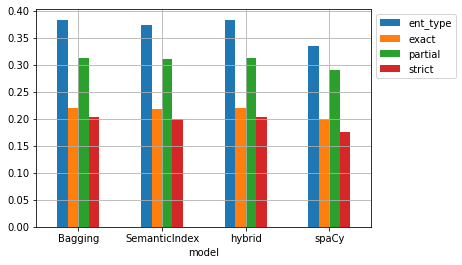

In [ ]:
ax = total_eval_dev['F1'].unstack().plot.bar(rot=0,grid=True)
ax.legend(bbox_to_anchor=(1, 1))
ax.plot(figsize=(20, 20))



In [97]:
# total_eval_test = pd.concat([df_base_test, ml_df_test, hybrid_df_test, df_perloctime_test])
total_eval_test = pd.concat([df_base_test, ml_df_test, df_perloctime_test])

total_eval_test


P         R        F1
model         eval                                  
SemanticIndex ent_type  0.203822  0.172973  0.187135
              partial   0.308917  0.262162  0.283626
              strict    0.156051  0.132432  0.143275
              exact     0.267516  0.227027  0.245614
Bagging       ent_type  0.210000  0.191489  0.200318
              partial   0.300000  0.273556  0.286169
              strict    0.163333  0.148936  0.155803
              exact     0.260000  0.237082  0.248013
CNN           ent_type  0.252336  0.568421  0.349515
              partial   0.220405  0.496491  0.305286
              strict    0.126168  0.284211  0.174757
              exact     0.144860  0.326316  0.200647

In [ ]:
print(total_eval_test.round(decimals=3).to_latex())

\begin{tabular}{llrrr}
\toprule
      &       &      P &      R &     F1 \\
model & eval &        &        &        \\
\midrule
SemanticIndex & ent\_type &  0.385 &  0.150 &  0.215 \\
      & partial &  0.497 &  0.193 &  0.278 \\
      & strict &  0.195 &  0.076 &  0.109 \\
      & exact &  0.351 &  0.136 &  0.196 \\
XGBoost & ent\_type &  0.393 &  0.147 &  0.214 \\
      & partial &  0.509 &  0.191 &  0.278 \\
      & strict &  0.202 &  0.076 &  0.110 \\
      & exact &  0.363 &  0.136 &  0.198 \\
hybrid & ent\_type &  0.393 &  0.147 &  0.214 \\
      & partial &  0.509 &  0.191 &  0.278 \\
      & strict &  0.202 &  0.076 &  0.110 \\
      & exact &  0.363 &  0.136 &  0.198 \\
spaCy & ent\_type &  0.693 &  0.551 &  0.614 \\
      & partial &  0.603 &  0.479 &  0.534 \\
      & strict &  0.310 &  0.246 &  0.274 \\
      & exact &  0.357 &  0.284 &  0.316 \\
\bottomrule
\end{tabular}



[]

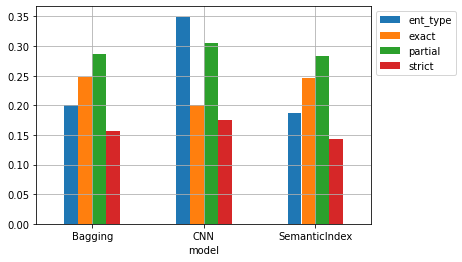

In [98]:
ax = total_eval_test['F1'].unstack().plot.bar(rot=0,grid=True)
ax.legend(bbox_to_anchor=(1, 1))
ax.plot(figsize=(20,20))

In [ ]:
print(total_eval_dev.join(total_eval_test, lsuffix='left_', rsuffix='right_').round(decimals=3).to_latex())

\begin{tabular}{llrrrrrr}
\toprule
      &       &  Pleft\_ &  Rleft\_ &  F1left\_ &  Pright\_ &  Rright\_ &  F1right\_ \\
model & eval &         &         &          &          &          &           \\
\midrule
SemanticIndex & ent\_type &   0.510 &   0.271 &    0.354 &    0.385 &    0.150 &     0.215 \\
      & partial &   0.439 &   0.234 &    0.305 &    0.497 &    0.193 &     0.278 \\
      & strict &   0.263 &   0.140 &    0.183 &    0.195 &    0.076 &     0.109 \\
      & exact &   0.302 &   0.161 &    0.210 &    0.351 &    0.136 &     0.196 \\
XGBoost & ent\_type &   0.526 &   0.272 &    0.359 &    0.393 &    0.147 &     0.214 \\
      & partial &   0.445 &   0.230 &    0.303 &    0.509 &    0.191 &     0.278 \\
      & strict &   0.271 &   0.140 &    0.185 &    0.202 &    0.076 &     0.110 \\
      & exact &   0.304 &   0.157 &    0.207 &    0.363 &    0.136 &     0.198 \\
hybrid & ent\_type &   0.526 &   0.272 &    0.359 &    0.393 &    0.147 &     0.214 \\
      & partial &   

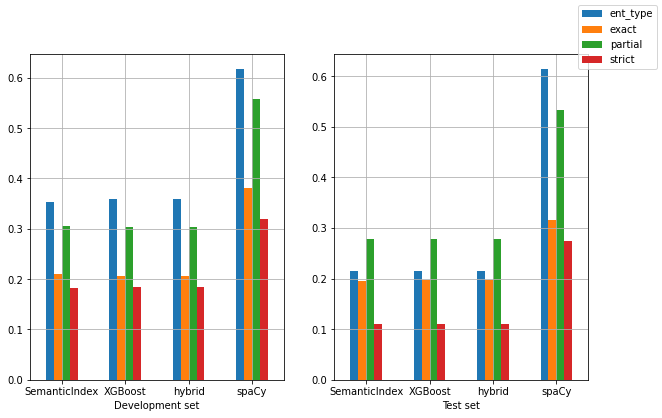

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

total_eval_dev['F1'].unstack().plot.bar(rot=0,grid=True, ax=axes[0], legend=False, xlabel='Development set')

total_eval_test['F1'].unstack().plot.bar(rot=0,grid=True, ax=axes[1], legend=False, xlabel='Test set')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

In [99]:
# total_eval_dev_type = pd.concat([df_base_dev_type, ml_df_dev_type, hybrid_df_dev_type, df_perloctime_dev_type])
total_eval_dev_type = pd.concat([df_base_dev_type, ml_df_dev_type, df_perloctime_dev_type])

total_eval_dev_type

PER       LOC      TIME     MISC
model         eval                                           
SemanticIndex ent_type  0.403101   0.28169  0.491429        0
              partial   0.322997  0.285211      0.36  0.21875
              strict    0.222222  0.183099  0.182857        0
              exact      0.22739  0.225352  0.205714   0.1875
Bagging       ent_type  0.403101  0.294118       0.5      NaN
              partial   0.322997  0.297794  0.343023      NaN
              strict    0.222222  0.191176  0.186047      NaN
              exact      0.22739  0.235294  0.186047      NaN
CNN           ent_type  0.410423     0.305  0.414286      NaN
              partial   0.439739     0.275  0.214286      NaN
              strict    0.234528     0.225  0.014286      NaN
              exact     0.306189     0.235  0.014286      NaN

In [100]:
# total_eval_test_type = pd.concat([df_base_test_type, ml_df_test_type, hybrid_df_test_type, df_perloctime_test_type])
total_eval_test_type = pd.concat([df_base_test_type, ml_df_test_type, df_perloctime_test_type])

total_eval_test_type

PER       LOC      TIME      MISC
model         eval                                            
SemanticIndex ent_type  0.209524  0.088235  0.363636         0
              partial   0.228571  0.362745  0.338843  0.159091
              strict    0.171429  0.068627  0.247934         0
              exact     0.184127  0.343137  0.280992  0.136364
Bagging       ent_type  0.210191  0.081218  0.372881       NaN
              partial    0.22293  0.370558  0.313559       NaN
              strict    0.171975  0.071066  0.254237       NaN
              exact     0.178344   0.35533  0.254237       NaN
CNN           ent_type   0.38565   0.27907  0.468085       NaN
              partial   0.349776  0.268734  0.244681       NaN
              strict    0.192825  0.196382         0       NaN
              exact     0.219731   0.22739         0       NaN

In [ ]:
x = total_eval_dev_type.join(total_eval_test_type, lsuffix='left_', rsuffix='right_')
print(x.astype(float).round(3).to_latex())

\begin{tabular}{llrrrrrr}
\toprule
      &       &  PERleft\_ &  LOCleft\_ &  TIMEleft\_ &  PERright\_ &  LOCright\_ &  TIMEright\_ \\
model & eval &           &           &            &            &            &             \\
\midrule
SemanticIndex & ent\_type &     0.375 &     0.247 &      0.519 &      0.217 &      0.112 &       0.460 \\
      & partial &     0.323 &     0.236 &      0.403 &      0.208 &      0.316 &       0.336 \\
      & strict &     0.222 &     0.116 &      0.234 &      0.125 &      0.059 &       0.195 \\
      & exact &     0.236 &     0.158 &      0.260 &      0.133 &      0.253 &       0.195 \\
XGBoost & ent\_type &     0.375 &     0.252 &      0.530 &      0.217 &      0.106 &       0.464 \\
      & partial &     0.323 &     0.241 &      0.384 &      0.208 &      0.318 &       0.330 \\
      & strict &     0.222 &     0.119 &      0.238 &      0.125 &      0.061 &       0.196 \\
      & exact &     0.236 &     0.161 &      0.238 &      0.133 &      0.258 &   

<AxesSubplot:xlabel='Test set'>

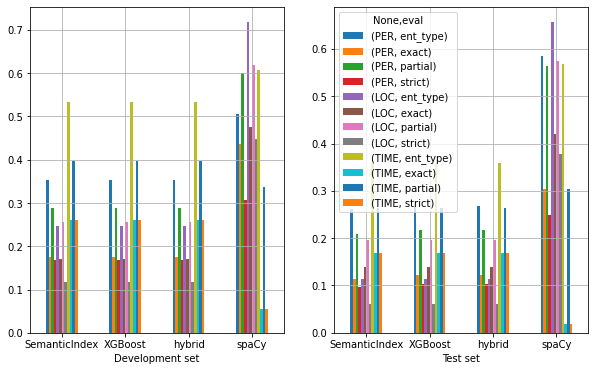

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

total_eval_dev_type.unstack().plot.bar(rot=0,grid=True, ax=axes[0], legend=False, xlabel='Development set')

total_eval_test_type.unstack().plot.bar(rot=0,grid=True, ax=axes[1], legend=True, xlabel='Test set')

# handles, labels = ax.get_legend_handles_labels()
# fig.legend( loc='upper right')

In [ ]:

def conll2json(path:str):

    with open(path, 'r', encoding='utf-8') as f:
        data = f.readlines()
    data = data[5:]

    data = filter(lambda x: not x.startswith('\n'), data)
    data = filter(lambda x: not x.startswith('#'), data)

    list_sent = [{"sent": [], "ents": [{}]}]
    is_ent = False
    for line in data:
        t_line = line.split('\t')
        # print(t_line)
        text = t_line[0]
        ent_type = t_line[1]
        comment = t_line[-1]
        # print(text, ent_type, comment)

        list_sent[-1]['sent'].append(text)

        if not 'NoSpaceAfter' in comment:
            list_sent[-1]['sent'].append(' ')

        if ent_type == 'O':
            if is_ent:  
                is_ent = False
                list_sent[-1]['ents'].append({})
        else:
            # print(ent_type)
            # print(list_sent[-1])
            if ent_type.startswith('B'):
                is_ent = True 
                list_sent[-1]['ents'][-1]['type'] = ent_type.split('-')[-1]
                list_sent[-1]['ents'][-1]['text'] = [text]
            else:

                list_sent[-1]['ents'][-1]['text'].append(text)
                if not 'NoSpaceAfter' in comment:
                    list_sent[-1]['ents'][-1]['text'].append(' ')

        if 'PySBDSegment' in comment:
            if not is_ent:
                list_sent[-1]['joined_sent'] = ''.join(list_sent[-1]['sent'])
                for x in list_sent[-1]['ents']:
                    if x:
                        x['text'] = ''.join(x['text'])
                list_sent.append({"sent": [], "ents": [{}]})

    for sent in list_sent:
        sent['ents'] = list(filter(lambda x: x, sent['ents']))
        for ent in sent['ents']:
            re_search_ent = re.search(re.escape(ent['text']), sent['joined_sent'])
            if re_search_ent:
                ent['start_char'], ent['end_char'] = re_search_ent.span()[0], re_search_ent.span()[1]
            #     print(ent)
            # tok_ent = ent['text'].split()
            # pos_tok = [i for i, x in enumerate(sent['sent']) if x in tok_ent]
            # print(tok_ent)
            # print(sent['sent'])
            # print(pos_tok)
            # print()

                # print(start_char, end_char)
        # break
    return list_sent[:-1]

In [ ]:
train_path = '../data/fr-ner-per-loc/HIPE-data-v1.4-train-fr.tsv'
dev_path = '../data/fr-ner-per-loc/HIPE-data-v1.4-dev-fr.tsv'
test_path = '../data/fr-ner-per-loc/HIPE-data-v1.4-test-fr.tsv'

train_data = conll2json(train_path)
dev_data = conll2json(dev_path)
test_data = conll2json(test_path)


In [ ]:
# project = '../data/Q5/'
project = '../data/Q5-clean'

model = IndexModel(semanticIndexPath=project, syntacticIndexPath=project)


In [ ]:
model.semanticIndex

,occupation,placeOfBurial,placeOfBirth,spouse,causeOfDeath,dateOfBirth,dateOfDeath,educatedAt
militaire_NOUN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
écrivain_NOUN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
naître_VERB,0.006418,0.054731,0.614022,0.095221,0.000000,0.712143,0.322065,0.0
voir_VERB,0.317739,0.000000,0.646827,0.000000,0.000000,0.000000,0.693294,0.0
mourir_VERB,0.000000,0.044637,0.000000,0.000000,0.104178,0.000000,0.993556,0.0
...,...,...,...,...,...,...,...,...
produire_VERB,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
document_NOUN,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
octroyer_VERB,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
quasi-totalité_NOUN,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0


In [ ]:
model.syntacticIndex

{' _SPACE': [{'graph': <networkx.classes.digraph.DiGraph at 0x7fe9645dbac0>,
   'size': 6,
   'props': [{'name': 'causeOfDeath', 'support': 1}],
   'ambiguous': 0,
   'source_types': ['Q5'],
   'source_nodes': [7],
   'target_types': ['Q9687'],
   'target_nodes': [41],
   'i': 0},
  {'graph': <networkx.classes.digraph.DiGraph at 0x7fe9645bbb50>,
   'size': 7,
   'props': [{'name': 'placeOfBurial', 'support': 1}],
   'ambiguous': 0,
   'source_types': ['Q5'],
   'source_nodes': [0],
   'target_types': ['Q1135636'],
   'target_nodes': [38],
   'i': 1},
  {'graph': <networkx.classes.digraph.DiGraph at 0x7fe963e94a60>,
   'size': 48,
   'props': [{'name': 'Other', 'support': 1}],
   'ambiguous': 0,
   'source_types': [],
   'source_nodes': [],
   'target_types': [],
   'target_nodes': [],
   'i': 2}],
 'abattre_VERB': [{'graph': <networkx.classes.digraph.DiGraph at 0x7fe963e94970>,
   'size': 2,
   'props': [{'name': 'dateOfDeath', 'support': 1}],
   'ambiguous': 0,
   'source_types': ['Q5

In [ ]:

# nlp = spacy.load('fr_core_news_lg')
nlp = spacy.load('fr_dep_news_trf')


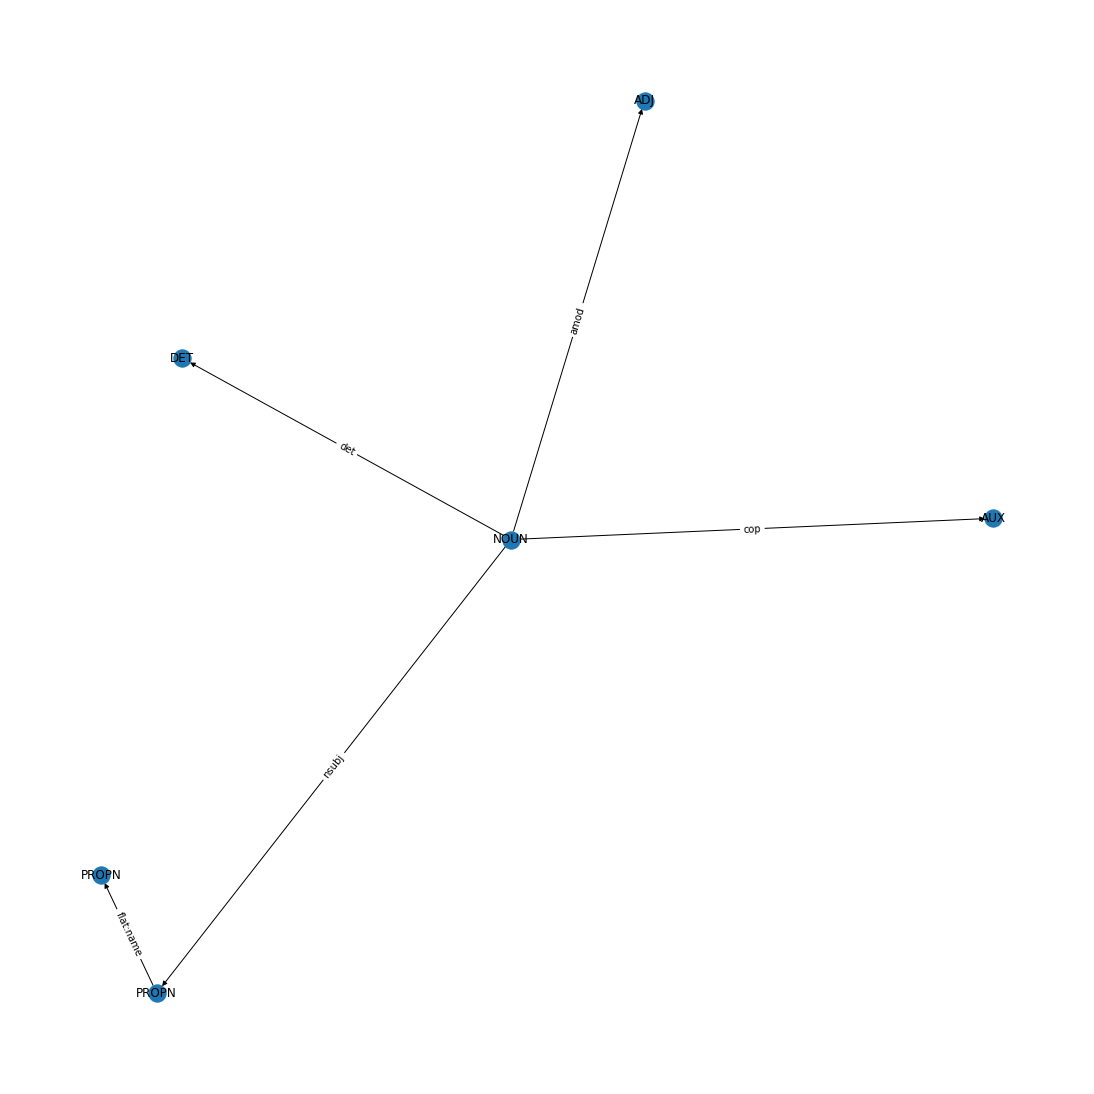

In [ ]:
text = 'Saulieu, 10 mai, obsèques du grand sculpteur animalier François Pompon.'
# text = "François Pompon fut l'élève du sculpteur dijonnais Sameron, puis d'Aimé Millet, et travailla plus tard comme praticien chez Mercié et Rodin"
# text = "François POMPON né à Saulieu le 9 mai 1855, mort le 6 mai 1933."
# text = "M. DE Latine de Puyfoucault, au château de Chanteau par Saulieu, Côte-d'Or."
# text =  "Thoisy-la-Berchère, canton de Saulieu, Côte-d'Or."
# text = "François POMPON est né à Saulieu le 9 mai 1855."
text = "François POMPON est un sculpteur bourguignon"
# text = "Le 3 janvier est décédé à Fribourg, à l'âge de 70 ans, M. Alphonse von der Weid, ancien officier au service de Naples. "
# text = "Alphonse von der Weid est décédé le 3 janvier"
# text = "M. Alphonse von der Weid a été enterré à Zurich"
# text = "François Pompon commence ses études"

doc = nlp(text)
dict_graph = doc2graph(doc)
# print(dict_graph)
# print(text)

# for token in doc:
#     print(token, token.lemma_, token.pos_)
vizGraph(dict_graph['graph'], label='pos')

# print(dict_graph)
candidates = model.extractCandidatesFromGraph(dict_graph['graph'], fuzzyMatch=True)
# print(list(candidates))
# candidates = list(candidates)
# if candidates:
for c in candidates:
    pred = model.classify(c['candidate']['graph'], thresh=.0)

    print('=====================')

    print(text)

    # print(sent['ents'])
    # print(dict_graph)

    print(c)
    print(pred)
    # print(dict_graph['graph'].nodes[18])
    print()

    print('=====================')

In [ ]:
for sent in train_data:
# for sent in dev_data:

    text = sent['joined_sent']

    # print(sent['ents'])
    doc = nlp(text)
    dict_graph = doc2graph(doc)
    # print(text)

    # print(dict_graph)
    candidates = model.extractCandidatesFromGraph(dict_graph['graph'], fuzzyMatch=False)
    # candidates = list(candidates)
    # if candidates:
    for c in candidates:
        pred = model.classify(c['candidate']['graph'], thresh=.0)

        print('=====================')

        print(text)

        print(sent['ents'])
        # print(dict_graph)

        print(c)
        print(pred)
        # print(dict_graph['graph'].nodes[18])
        print()

        print('=====================')

        # break
    # pred = model.classify(dict_graph['graph'])
    # print(pred)
    # vizGraph(dict_graph['graph'], label='text')
    # break     

De son côté, le « Forest » devra jouer sans son arrière gauche, Colin Barrett, blessé samedi dernier. 
[{'type': 'pers', 'text': 'arrièregauche, Colin Barrett'}]
{'anchorNode': 8, 'anchorText': 'devoir_VERB', 'candidate': {'nodes': [8, 2, 6], 'labels': [{'name': 'occupation', 'support': 1}], 'graph': <networkx.classes.digraph.DiGraph object at 0x7fad06c86370>}}
{'pred': 'occupation', 'score': 0.948278218782944, 'rule': 'semantic', 'source_type': 'Q5', 'source_node': 2, 'target_type': 'Q116', 'target_node': 6}

Vingt ans sous la lampe Petit-fils de Ferdinand Porchat, qui présida la Ville de Neuchâtel, fils de Charles qui enseigna à l'ESC, le jeune Jean-Pierre fait ici des études supérieures de commerce qu'il parfait lors de stages à Berne, Zurich et Londres. 
[{'type': 'pers', 'text': 'FerdinandPorchat'}, {'type': 'loc', 'text': 'Villede Neuchâtel'}, {'type': 'pers', 'text': 'Charles', 'start_char': 100, 'end_char': 107}, {'type': 'pers', 'text': 'jeuneJean-Pierre '}, {'type': 'loc', 't

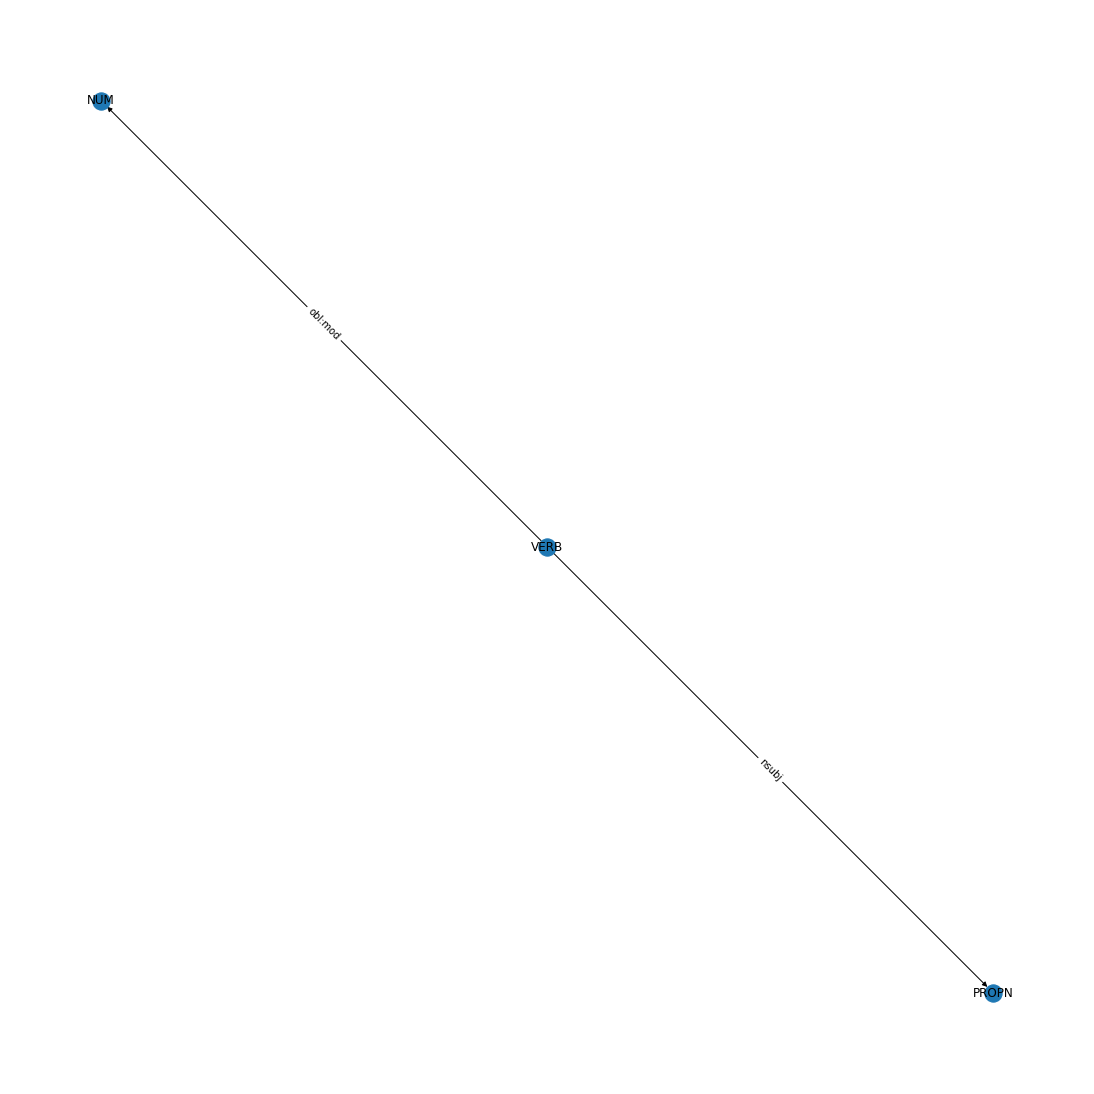

In [ ]:
vizGraph(model.syntacticIndex['décéder_VERB'][1]['graph'], label='pos')

In [ ]:
import re 
import os 
from tqdm import tqdm 
from glob import glob 

sent_re = re.compile(r'<sent[^>]*>([^</]*)')
# data = []


all_files = glob('/Volumes/T7/THESE/CORPUS/**/**_docbook.xml', recursive=True)

total = 0
for filepath in tqdm(all_files):
    # print(filepath)
    filename = filepath.replace('_docbook.xml', '')
    # print(filename)
    with open(filepath, encoding='utf-8') as f:
        file = f.read()
    corpus = sent_re.findall(file)
    total += len(corpus)


100%|██████████| 8857/8857 [00:53<00:00, 165.12it/s]


In [ ]:
total

15185305